<a href="https://colab.research.google.com/github/ZKisielewska/learning-git-task/blob/master/M_15_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advanced ML (creating pipelines)**

We will use the [Titanic](https://uploads.kodilla.com/bootcamp/ds/15/titanic.csv) dataset.

We have already done data processing for it, but now let's put this processing in Pipeline.

Let's load the needed libraries in this module:

In [76]:
# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# split of data into training/validation/test sets
from sklearn.model_selection import train_test_split, GridSearchCV

# creating Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# dimensionality reduction
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

For this case we will not go through exploratory data analysis again because we have done it in the previous case. We will load **titanic.csv**, and then we will **split** the data into **training and test sets**. Our **dependent variable (y)** is whether the **passenger will survive the crash or not**. When splitting the data, we set **25%** of the observations to the **test set** while **stratifying** is y. Thanks to this, the distribution between classes will be the same for the training subset as for the test subset).

In [77]:
dataset = pd.read_csv('https://uploads.kodilla.com/bootcamp/ds/15/titanic.csv')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [78]:
X = dataset.drop(['Survived'], axis=1).copy()
y = dataset['Survived'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

At the **input of the Pipeline**, we get **raw data**.0

Then, the following processes are performed in Pipoeline:

- we fill in the missing values,
- we remove incorrect data or outliers,
- we standardize the data if we use a parametric model,
- we do dimensionality reduction,
- we do feature engineering,
- we process categorical variables,
- the last step is to train the model.

In Pipeline, we can separate operations depending on the columns. Thus, we do not have to deal with all at once. We'll start with the numbers first.

As **numerical** we can consider:
- **Age** (age),
- **SibSp** (siblings or spouses on board),
- **Parch** (parents and children on board),
- **Fare** (ticket fare).

In [79]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']

We know from exploratory data analysis that there are **missing values for age**. We should complete them, so we create a Pipeline for numeric variables named **num_preparation**, in which we place **SimpleImputer** from the **Scikit-Learn** library. This Transformer fills in missing values based on the chosen strategy, for numeric variables it can be mean or median. These statistics are calculated from the training set (**fit**) and, based on these statistics, missing values (**transforms**) are supplemented for the test set, as well as in production for completely new data. This will also work well if deficiencies occur for other characteristics. Therefore, there will be no data leakage and the process will be fully automatic.

In [80]:
# preparation of numeric values
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

We can **fit** this Pipeline and then **transform** it on the training set. Keep in mind that in the Pipeline output using the Transformers that are available in scikit-learn, we will get a **numpy array**, not a Pandas DataFrame.

In [81]:
print('Raw dataset - training set:')
print(X_train[num_features].isnull().mean())
X_train_transformed = num_preparation.fit_transform(X_train[num_features])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=num_features)
print('\nOutput Pipeline - training set')
print(X_train_transformed[num_features].isnull().mean())

Raw dataset - training set:
Age      0.196108
SibSp    0.000000
Parch    0.000000
Fare     0.000000
dtype: float64

Output Pipeline - training set
Age      0.0
SibSp    0.0
Parch    0.0
Fare     0.0
dtype: float64


We already have a 'learned' Pipeline, now we can transform new data - such as a test set. **For the test set, we cannot fit**, we only use transform, i.e. the data will be supplemented with the average from the training set.

In [82]:
print('Raw dataset - test set:')
print(X_test[num_features].isnull().mean())
X_test_transformed = num_preparation.transform(X_test[num_features])
X_test_transformed = pd.DataFrame(X_test_transformed, columns=num_features)
print('\nOutput Pipeline - Test set')
print(X_test_transformed[num_features].isnull().mean())

Raw dataset - test set:
Age      0.206278
SibSp    0.000000
Parch    0.000000
Fare     0.000000
dtype: float64

Output Pipeline - Test set
Age      0.0
SibSp    0.0
Parch    0.0
Fare     0.0
dtype: float64


# **Column Transformer**

However, **the above transformation cannot be used for categorical variables**, so we should distribute the operations between the columns. Therefore, we will use the **Column Transformer**, to which we provide the entire data set and it splits the data into different Pipelines that perform their operations. At the end, the outputs from the outputs are combined.

So we will create a **Pipeline data_preparation** based on **ColumnTransformer**, which at the moment only has data preparation for numeric values. We **provide the name of the Pipeline** in the string (it will be useful if later in GridSearch you want to change the strategy of imputation of numerical values and treat it as a **hyperparameter** - after all, the model can work better with the median). We also add a variable that refers to the Pipeline and features that are used by this Pipeline.

In [83]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']

# preparation of numeric values
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

# transformer = numerical and categorical values
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

We can pass **X_train** with all features to **data_preparation**, it already knows which operations are to be performed for which features.

In [84]:
data_preparation.fit_transform(X_train)

array([[35.    ,  1.    ,  0.    , 90.    ],
       [19.    ,  0.    ,  0.    , 10.5   ],
       [34.    ,  0.    ,  0.    , 13.    ],
       ...,
       [48.    ,  1.    ,  3.    , 34.375 ],
       [47.    ,  0.    ,  0.    , 38.5   ],
       [27.    ,  0.    ,  0.    ,  8.6625]])

In the output we get a matrix with four columns, so with the number of columns we indicated for the Pipeline in the input, they are only **numeric variables**.

# **Custom Transformers**

We have a **Name** column from which it is impossible to extract information based on existing **Transformers** in **scikit-learn**. Also, we cannot treat all values as **categorical**, because there are also **rare categories** that occur at least once.

Let's create our own **Transformer FilterName** based on **Custom Transformer**. This allows you to create any operation. In some situations, the standard scikit-learn classes may not be sufficient for your particular problem, so you'll need to create your own **custom transformer**.

Such a custom class, to be used as a step in Pipeline, must inherit **BaseEstimator** and **TransformerMixin**, as well as have a **fit** and **transform** method. Our custom Transformer will extract the prefix from the Name column and treat all other than 'Mr', 'Miss', 'Mrs' as 'Other'. It's the same thing we did during Feature Engineering, but now it will be included in the Transformer. This Transformer needs nothing in the fit function.

In [85]:
class Filter_Name(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y = None ):
        return self

    def transform(self, X, y = None ):
        X_transformed = X.copy()
        column = self.column
        X_transformed[column] = X_transformed[column].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
        X_transformed.loc[~X_transformed[column].isin(['Mr', 'Miss', 'Mrs']), column] = 'Other'
        return X_transformed

The transformer only changes **one column**, the other variables remain unchanged. Let's check the operation of the **Transformer** for the **'Name'** column in **X_train**.

In [86]:
transformer_filter_name = Filter_Name(column='Name')
display(X_train[['Name']])
display(transformer_filter_name.fit_transform(X_train[['Name']]))

,Name
486,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)"
238,"Pengelly, Mr. Frederick William"
722,"Gillespie, Mr. William Henry"
184,"Kink-Heilmann, Miss. Luise Gretchen"
56,"Rugg, Miss. Emily"
...,...
547,"Padro y Manent, Mr. Julian"
469,"Baclini, Miss. Helene Barbara"
736,"Ford, Mrs. Edward (Margaret Ann Watson)"
462,"Gee, Mr. Arthur H"


,Name
486,Mrs
238,Mr
722,Mr
184,Miss
56,Miss
...,...
547,Mr
469,Miss
736,Mrs
462,Mr


Based on this **Transformer**, we will create a Pipeline **cat_preparation** for **categorical variables**. As variables we will use:
- **Name** (passenger's name with a prefix),
- **Sex** (gender),
- **Embarked** (place where the passenger left).

The other variables are removed because there are many missing or missing information that the model could use.

In [87]:
cat_features = ['Name', 'Sex', 'Embarked']

# preparation of categorical values
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column = 'Name'))
])

Now let's use this Pipeline for categorical variables.

In [88]:
print('Before')
display(X_train[cat_features])
print('After')
display(cat_preparation.fit_transform(X_train[cat_features]))

Before


,Name,Sex,Embarked
486,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,S
238,"Pengelly, Mr. Frederick William",male,S
722,"Gillespie, Mr. William Henry",male,S
184,"Kink-Heilmann, Miss. Luise Gretchen",female,S
56,"Rugg, Miss. Emily",female,S
...,...,...,...
547,"Padro y Manent, Mr. Julian",male,C
469,"Baclini, Miss. Helene Barbara",female,C
736,"Ford, Mrs. Edward (Margaret Ann Watson)",female,S
462,"Gee, Mr. Arthur H",male,S


After


,Name,Sex,Embarked
486,Mrs,female,S
238,Mr,male,S
722,Mr,male,S
184,Miss,female,S
56,Miss,female,S
...,...,...,...
547,Mr,male,C
469,Miss,female,C
736,Mrs,female,S
462,Mr,male,S


As you can see, the other variables have not been changed. However, the Pipeline for categorical variables is not fully done, the computer doesn't understand 'words'. However, before we change the unique categories to **binary variables (One Hot Encoder)**, the missing values must be completed. Here we will use the **most_frequent method**, i.e. **the most frequent category**.

In [89]:
# preparation of categorical values
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
cat_preparation.fit_transform(X_train[cat_features])

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

The **shape** of the **processed X_train** for categorical variables is:

In [90]:
print(cat_preparation.fit_transform(X_train[cat_features]).shape)

(668, 9)


# **Combination of operations for categorical and numeric variables**

It's time to connect both Pipelines and put them in **data_preparation**. We are sure that there is no data leakage here and the process is fully automatic. Such a saved Pipeline will be able to be saved as a *pickle* and loaded in a separate application or system, without having to repeat the preparation of raw steps. Often with this approach, we can make a human error, or there will be missing values for another column. Using Pipeline, we deal with these problems, we don't even have to think about them in the final product.

In [91]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

# preparation of numeric values
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
    ])

# preparation of categorical values
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])

# transformer = numerical and categorical values
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

Let's check the operation of **Pipelin**e to prepare data for **X_train**.

In [92]:
data_preparation.fit_transform(X_train)

array([[35.,  1.,  0., ...,  0.,  0.,  1.],
       [19.,  0.,  0., ...,  0.,  0.,  1.],
       [34.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [48.,  1.,  3., ...,  0.,  0.,  1.],
       [47.,  0.,  0., ...,  0.,  0.,  1.],
       [27.,  0.,  0., ...,  0.,  0.,  1.]])

We don't have to worry that there was a '**PassengerId**' or '**Ticket**' variable in the raw file because they were **rejected** from our collection. Then, data for numeric and categorical variables are prepared separately, and after processing, the data is combined.

# **Pipeline connection to the model**

We will use **logistic regression** as a model.

Such a model can be **trained on a training set**, and then make a **prediction on a test set** and **evaluate** it.

So let's train our first Pipeline, i.e. the part responsible for **data preparation**, as well as the **model**, which is the **last step in Pipeline**.

In [93]:
# numerical features
num_features = ['Age', 'SibSp', 'Parch', 'Fare']

# categorical features
cat_features = ['Name', 'Sex', 'Embarked']

# preparation of numeric values
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

# preparation of categorical values
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# transformer = numerical and categorical values
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

Such a Pipeline can be **trained** on the **training set**, we do it exactly the same as we trained the models before, using the **fit** method and **specifying X** and **y**.

In [94]:
model_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('filter_name',
                                                                   Filter_Name(column='Name')),
                                                                  ('fill_missings',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Name', 'Sex',
                                                   'Embarked'])])),
                ('model', LogisticRegression(max_iter=10000))])

We will use the **function** from the **classification** module to evaluate the model.

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       137
           1       0.74      0.72      0.73        86

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



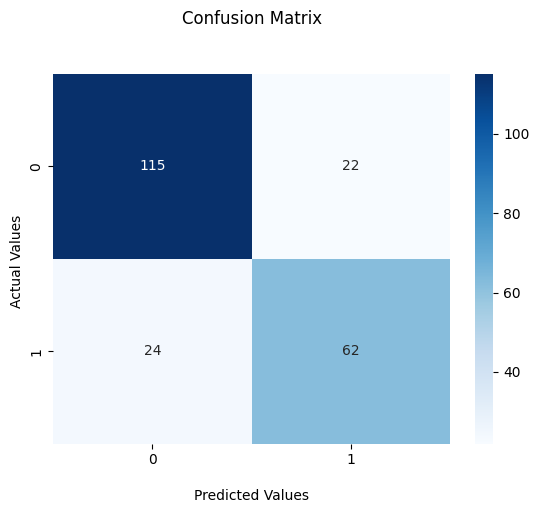

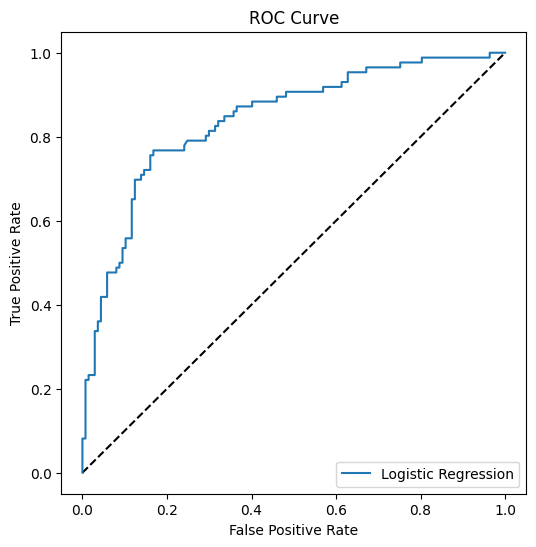

,Model,F1_score,AUC
0,Logistic Regression,0.729412,0.840562


In [95]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metrics for the tested model ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)

However, our data is not fully prepared, we use a parametric model which is **Logistic Regression**, so it should receive **scaled data**. In addition, relationships can be non-linear for numeric variables. So we add the **polynomial**, then **standardize the numeric variables**. Is it the end? Not necessarily. Some of the variables will be correlated with each other and will carry the same information, so we will use **PCA** - Principal Components Analysis. After its result, the data does not need to be scaled, so the data should be **standardized again**.

In [96]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

# preparation of numeric values
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# preparation of categorical values
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# transformer = numerical and categorical values
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

model_pipeline_v2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('filter_name',
                                                                   Filter_Name(column='Name')),
                                                                  ('fill_missings',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Name', 'Sex',
                                                   'Embarked'])])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       137
           1       0.75      0.76      0.75        86

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



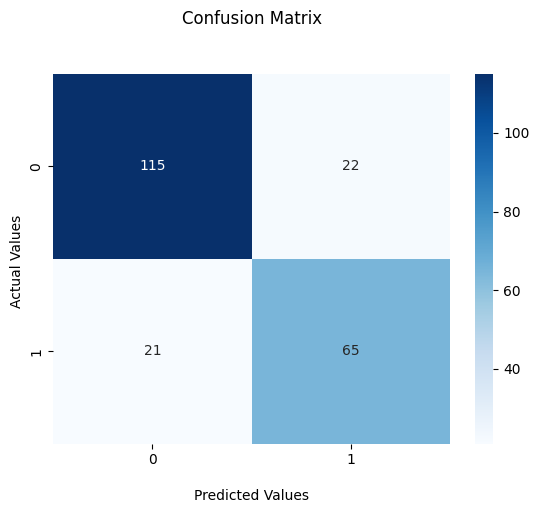

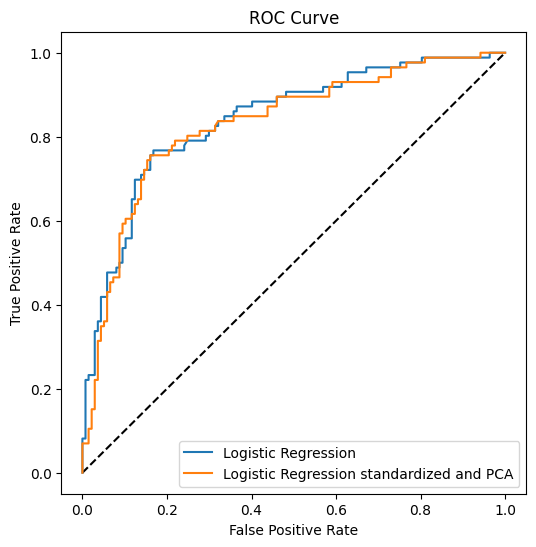

,Model,F1_score,AUC
0,Logistic Regression,0.729412,0.840562
1,Logistic Regression standardized and PCA,0.751445,0.830122


In [97]:
calculate_metrics(model_pipeline_v2, 'Logistic Regression standardized and PCA', X_test, y_test)

We added new steps in the model training process, and the results are no better – they are very comparable, slightly worse.

The last model we will use will be like the previous one, but with a selection of **hyperparameters**.

In [98]:
model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

Referring to **hyperparameters** is not like before, so we need to **get names and references to them in our Pipeline**. In addition, we also have more hyperparameters at this point, because the data preparation steps have also become a hyperparameter.

This is one of the biggest advantages of using data pipelines. Our model is no longer just a machine learning algorithm, but also the previous steps of the data pipeline. Multiple data pipeline steps mean multiple hyperparameters that can be optimized.

In [99]:
list(model_pipeline_v3.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__numeric_preprocessing',
 'preprocessor__categorical_preprocessing',
 'preprocessor__numeric_preprocessing__memory',
 'preprocessor__numeric_preprocessing__steps',
 'preprocessor__numeric_preprocessing__verbose',
 'preprocessor__numeric_preprocessing__fill_missings',
 'preprocessor__numeric_preprocessing__polynomial_features',
 'preprocessor__numeric_preprocessing__scaler_1',
 'preprocessor__numeric_preprocessing__pca',
 'preprocessor__numeric_preprocessing__scaler_2',
 'preprocessor__numeric_preprocessing__fill_missings__add_indicator',
 'preprocessor__numeric_preprocessing__fill_missings__copy',
 'preprocessor__numeric_preprocessing__fill_missings__fill_value',
 'preprocessor__numeric_pr

We will create a **GridSearch** for our **Pipeline** with the model and **train it**.

In [101]:
params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(model_pipeline_v3, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_v3 = grid_search.best_estimator_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Wybrane hiperparametry:  {'model__C': 0.12648552168552957, 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.99, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 3}


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       137
           1       0.75      0.72      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



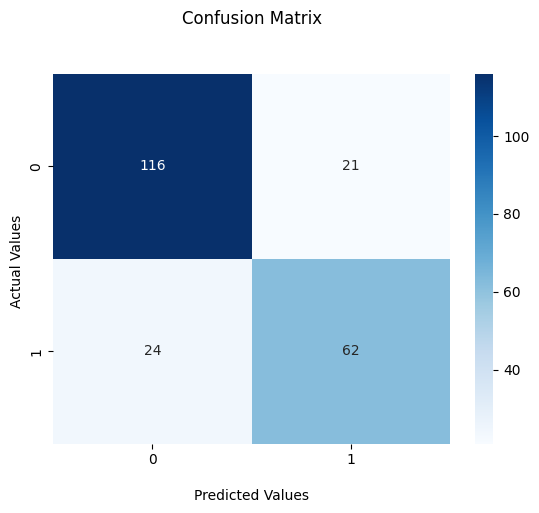

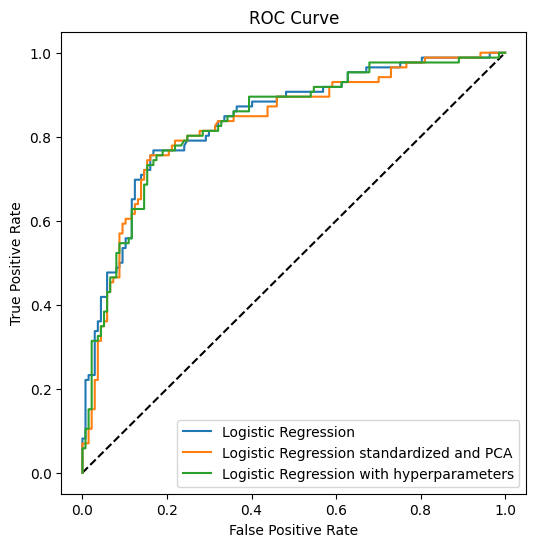

,Model,F1_score,AUC
0,Logistic Regression,0.729412,0.840562
1,Logistic Regression standardized and PCA,0.751445,0.830122
2,Logistic Regression with hyperparameters,0.733728,0.836318


In [102]:
calculate_metrics(model_v3, 'Logistic Regression with hyperparameters', X_test, y_test)

The results are not significantly better, but this approach is the most desirable in Data Science - a **Pipeline** created for **data preparation and modeling**, for which **hyperparameters** are then **selected based on validation sets**.